#### Import Libraries

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from datasets import load_dataset

#### Read Dataset and split into train and test

In [2]:
df = pd.read_csv('../data/amazon_electronics.csv')

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [4]:
train_df.__len__(), test_df.__len__()

(4000, 1000)

#### Add new sentiment column to the dataset

In [5]:
train_df['sentiment'] = train_df['overall'].apply(lambda x: 0 if x < 3 else (2 if x > 3 else 1))
test_df['sentiment'] = test_df['overall'].apply(lambda x: 0 if x < 3 else (2 if x > 3 else 1))

In [6]:
train_df.head()

,Unnamed: 0,asin,overall,reviewText,summary,Review_Length,sentiment
1375,2726396,B00877ZOYK,2.0,I received this product promptly from Amazon o...,"Less than four months old, and a flaw in the p...",2668.0,0
2680,6205902,B0018Z2YA0,3.0,I'm using this device on a fairly new Dell Stu...,"Works, But Inconvenient, With Poor Mic, Interf...",2993.0,1
42,487826,B000GAUZFO,1.0,I have been using this with my nano for about ...,Don't believe the hype.,5923.0,0
1495,555634,B000JNYWBG,2.0,As a dedicated iPod owner I was thrilled to le...,PRICEY AND SUFFERS FROM BUGS...,3070.0,0
295,4101812,B00IM7KYMC,1.0,"Wow, this might be the worst purchase I've eve...","Poor performance, poorly constructed, bad qual...",2534.0,0


#### Add sentiment label

In [7]:
def label_int2str(row):
    if row == 0:
        return 'negative'
    elif row == 1:
        return 'neutral'
    else:
        return 'positive'

In [8]:
train_df["sentiment_name"] = train_df['sentiment'].apply(lambda row: label_int2str(row))
train_df.head()

,Unnamed: 0,asin,overall,reviewText,summary,Review_Length,sentiment,sentiment_name
1375,2726396,B00877ZOYK,2.0,I received this product promptly from Amazon o...,"Less than four months old, and a flaw in the p...",2668.0,0,negative
2680,6205902,B0018Z2YA0,3.0,I'm using this device on a fairly new Dell Stu...,"Works, But Inconvenient, With Poor Mic, Interf...",2993.0,1,neutral
42,487826,B000GAUZFO,1.0,I have been using this with my nano for about ...,Don't believe the hype.,5923.0,0,negative
1495,555634,B000JNYWBG,2.0,As a dedicated iPod owner I was thrilled to le...,PRICEY AND SUFFERS FROM BUGS...,3070.0,0,negative
295,4101812,B00IM7KYMC,1.0,"Wow, this might be the worst purchase I've eve...","Poor performance, poorly constructed, bad qual...",2534.0,0,negative


In [9]:
test_df["sentiment_name"] = test_df['sentiment'].apply(lambda row: label_int2str(row))
test_df.head()

,Unnamed: 0,asin,overall,reviewText,summary,Review_Length,sentiment,sentiment_name
508,5959227,B01DWDEC4G,1.0,This is an extreme disappointment. I purchased...,25 Mile Range Max,3865.0,0,negative
3197,281023,B0002SQ2P2,4.0,I've had these speakers for about six weeks an...,Great hassle free 2.1 system at a great price,5279.0,2,positive
2863,53772,B000051SD1,3.0,I'm a drummer and have been involved with musi...,The Truth about these Headphones...,3110.0,1,neutral
4570,2605445,B007G51VEQ,5.0,First I must thank Amazon for their exceptiona...,Leading hardware and BIOS design - you get wha...,2514.0,2,positive
3671,3717777,B00F415LEU,4.0,Let me preface this review by saying for a lon...,"Unexpectedly brilliant, at least for an iOS de...",16996.0,2,positive


#### Declare model to train (fine-tune) and initialize the tokenizer

In [10]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

##### Sample tokenized text

In [11]:
text = "Tokenizing is a core task of nlp"
encoded_txt = tokenizer(text)
print(encoded_txt)

{'input_ids': [101, 19204, 6026, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokens = tokenizer.convert_ids_to_tokens(encoded_txt.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [13]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing is a core task of nlp [SEP]


In [14]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [15]:
inputs = tokenizer(train_df['reviewText'].tolist(), padding='max_length', truncation=True, max_length=512, return_tensors='pt')

In [16]:
inputs_test = tokenizer(test_df['reviewText'].tolist(), padding='max_length', truncation=True, max_length=512, return_tensors='pt')

In [17]:
inputs

{'input_ids': tensor([[  101,  1045,  2363,  ...,  2662,  1012,   102],
        [  101,  1045,  1005,  ...,  2677,  2296,   102],
        [  101,  1045,  2031,  ...,  3287,  2030,   102],
        ...,
        [  101,  1026,  1037,  ...,  1011,  1999,   102],
        [  101,  1045,  2031,  ..., 20919,  3096,   102],
        [  101,  4013,  2015,  ...,  1045,  1010,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

### Setting up environment for training

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
num_labels = 3
model = (DistilBertForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Defining performance metrics

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [21]:
from transformers import Trainer, TrainingArguments

In [22]:
len(inputs['input_ids'])

4000

#### Preparing the training and testing data

In [23]:
class AmazonReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare labels for the datasets
train_labels = train_df['sentiment'].tolist()
test_labels = test_df['sentiment'].tolist()
print(len(train_labels), len(test_labels))
# Create custom datasets
train_dataset = AmazonReviewDataset(inputs, train_labels)
test_dataset = AmazonReviewDataset(inputs_test, test_labels)

# Initialize the Trainer with the custom datasets



4000 1000


#### Training the model

In [35]:
batch_size = 8
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-amazon-electronics"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=50,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level='error')

In [36]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=train_dataset, eval_dataset=test_dataset, tokenizer=tokenizer)

In [37]:
trainer.train()

  0%|          | 0/25000 [00:00<?, ?it/s]

C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3982, 'learning_rate': 1.9600000000000002e-05, 'epoch': 1.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.4626332521438599, 'eval_accuracy': 0.617, 'eval_f1': 0.6315975017946878, 'eval_precision': 0.6713681759559413, 'eval_recall': 0.617, 'eval_runtime': 30.1211, 'eval_samples_per_second': 33.199, 'eval_steps_per_second': 4.15, 'epoch': 1.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3264, 'learning_rate': 1.9200000000000003e-05, 'epoch': 2.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.5764691829681396, 'eval_accuracy': 0.619, 'eval_f1': 0.6373812666360921, 'eval_precision': 0.6727402424802388, 'eval_recall': 0.619, 'eval_runtime': 31.4141, 'eval_samples_per_second': 31.833, 'eval_steps_per_second': 3.979, 'epoch': 2.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3055, 'learning_rate': 1.88e-05, 'epoch': 3.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8460007905960083, 'eval_accuracy': 0.616, 'eval_f1': 0.6312552194142227, 'eval_precision': 0.6708085702345641, 'eval_recall': 0.616, 'eval_runtime': 32.1611, 'eval_samples_per_second': 31.093, 'eval_steps_per_second': 3.887, 'epoch': 3.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2574, 'learning_rate': 1.8400000000000003e-05, 'epoch': 4.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.9016982316970825, 'eval_accuracy': 0.593, 'eval_f1': 0.6168769702717073, 'eval_precision': 0.6737602355119636, 'eval_recall': 0.593, 'eval_runtime': 32.7357, 'eval_samples_per_second': 30.548, 'eval_steps_per_second': 3.818, 'epoch': 4.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1709, 'learning_rate': 1.8e-05, 'epoch': 5.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.15547776222229, 'eval_accuracy': 0.643, 'eval_f1': 0.6532907006732249, 'eval_precision': 0.6697088409007014, 'eval_recall': 0.643, 'eval_runtime': 33.1385, 'eval_samples_per_second': 30.176, 'eval_steps_per_second': 3.772, 'epoch': 5.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1478, 'learning_rate': 1.76e-05, 'epoch': 6.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.4427366256713867, 'eval_accuracy': 0.621, 'eval_f1': 0.6333363773588253, 'eval_precision': 0.6647854160212228, 'eval_recall': 0.621, 'eval_runtime': 32.5871, 'eval_samples_per_second': 30.687, 'eval_steps_per_second': 3.836, 'epoch': 6.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1031, 'learning_rate': 1.72e-05, 'epoch': 7.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.5097429752349854, 'eval_accuracy': 0.625, 'eval_f1': 0.6351535129071785, 'eval_precision': 0.6502620387289961, 'eval_recall': 0.625, 'eval_runtime': 33.0593, 'eval_samples_per_second': 30.249, 'eval_steps_per_second': 3.781, 'epoch': 7.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0932, 'learning_rate': 1.6800000000000002e-05, 'epoch': 8.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.8340303897857666, 'eval_accuracy': 0.622, 'eval_f1': 0.6318306730441606, 'eval_precision': 0.660472238806935, 'eval_recall': 0.622, 'eval_runtime': 33.1502, 'eval_samples_per_second': 30.166, 'eval_steps_per_second': 3.771, 'epoch': 8.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0879, 'learning_rate': 1.64e-05, 'epoch': 9.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.6741137504577637, 'eval_accuracy': 0.638, 'eval_f1': 0.648883790402236, 'eval_precision': 0.666556810767175, 'eval_recall': 0.638, 'eval_runtime': 32.677, 'eval_samples_per_second': 30.603, 'eval_steps_per_second': 3.825, 'epoch': 9.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0676, 'learning_rate': 1.6000000000000003e-05, 'epoch': 10.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.8306806087493896, 'eval_accuracy': 0.61, 'eval_f1': 0.6288400734183189, 'eval_precision': 0.6755344504993335, 'eval_recall': 0.61, 'eval_runtime': 32.8567, 'eval_samples_per_second': 30.435, 'eval_steps_per_second': 3.804, 'epoch': 10.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0562, 'learning_rate': 1.5600000000000003e-05, 'epoch': 11.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.215977430343628, 'eval_accuracy': 0.606, 'eval_f1': 0.6122222116309702, 'eval_precision': 0.6571031207598371, 'eval_recall': 0.606, 'eval_runtime': 32.9457, 'eval_samples_per_second': 30.353, 'eval_steps_per_second': 3.794, 'epoch': 11.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0606, 'learning_rate': 1.5200000000000002e-05, 'epoch': 12.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.8721320629119873, 'eval_accuracy': 0.621, 'eval_f1': 0.6263199052493946, 'eval_precision': 0.635444845547604, 'eval_recall': 0.621, 'eval_runtime': 32.9336, 'eval_samples_per_second': 30.364, 'eval_steps_per_second': 3.796, 'epoch': 12.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0368, 'learning_rate': 1.48e-05, 'epoch': 13.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.1032378673553467, 'eval_accuracy': 0.642, 'eval_f1': 0.643064560436402, 'eval_precision': 0.6446973714244376, 'eval_recall': 0.642, 'eval_runtime': 29.7262, 'eval_samples_per_second': 33.64, 'eval_steps_per_second': 4.205, 'epoch': 13.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0435, 'learning_rate': 1.4400000000000001e-05, 'epoch': 14.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.3218026161193848, 'eval_accuracy': 0.641, 'eval_f1': 0.6431355158539942, 'eval_precision': 0.646062207566466, 'eval_recall': 0.641, 'eval_runtime': 29.6955, 'eval_samples_per_second': 33.675, 'eval_steps_per_second': 4.209, 'epoch': 14.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0537, 'learning_rate': 1.4e-05, 'epoch': 15.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.448566436767578, 'eval_accuracy': 0.619, 'eval_f1': 0.6351881825115953, 'eval_precision': 0.6738412342215989, 'eval_recall': 0.619, 'eval_runtime': 29.7001, 'eval_samples_per_second': 33.67, 'eval_steps_per_second': 4.209, 'epoch': 15.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0369, 'learning_rate': 1.3600000000000002e-05, 'epoch': 16.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.4309418201446533, 'eval_accuracy': 0.629, 'eval_f1': 0.6400700131043127, 'eval_precision': 0.6584350377276356, 'eval_recall': 0.629, 'eval_runtime': 29.7232, 'eval_samples_per_second': 33.644, 'eval_steps_per_second': 4.205, 'epoch': 16.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0276, 'learning_rate': 1.3200000000000002e-05, 'epoch': 17.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.6500444412231445, 'eval_accuracy': 0.627, 'eval_f1': 0.6286091300457519, 'eval_precision': 0.6369256437529064, 'eval_recall': 0.627, 'eval_runtime': 30.0845, 'eval_samples_per_second': 33.24, 'eval_steps_per_second': 4.155, 'epoch': 17.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0295, 'learning_rate': 1.2800000000000001e-05, 'epoch': 18.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.6480517387390137, 'eval_accuracy': 0.629, 'eval_f1': 0.6377082185388449, 'eval_precision': 0.6498827479338842, 'eval_recall': 0.629, 'eval_runtime': 29.7501, 'eval_samples_per_second': 33.613, 'eval_steps_per_second': 4.202, 'epoch': 18.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0398, 'learning_rate': 1.2400000000000002e-05, 'epoch': 19.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.4565205574035645, 'eval_accuracy': 0.632, 'eval_f1': 0.6314385092193849, 'eval_precision': 0.6342584428279742, 'eval_recall': 0.632, 'eval_runtime': 29.9553, 'eval_samples_per_second': 33.383, 'eval_steps_per_second': 4.173, 'epoch': 19.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0424, 'learning_rate': 1.2e-05, 'epoch': 20.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.1799185276031494, 'eval_accuracy': 0.636, 'eval_f1': 0.6437153896484895, 'eval_precision': 0.6549508888982729, 'eval_recall': 0.636, 'eval_runtime': 30.0126, 'eval_samples_per_second': 33.319, 'eval_steps_per_second': 4.165, 'epoch': 20.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0201, 'learning_rate': 1.16e-05, 'epoch': 21.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.693693161010742, 'eval_accuracy': 0.638, 'eval_f1': 0.6506514623579674, 'eval_precision': 0.6737424754685704, 'eval_recall': 0.638, 'eval_runtime': 29.907, 'eval_samples_per_second': 33.437, 'eval_steps_per_second': 4.18, 'epoch': 21.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0258, 'learning_rate': 1.1200000000000001e-05, 'epoch': 22.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.007307052612305, 'eval_accuracy': 0.611, 'eval_f1': 0.6210966380158538, 'eval_precision': 0.6491707944514502, 'eval_recall': 0.611, 'eval_runtime': 29.9806, 'eval_samples_per_second': 33.355, 'eval_steps_per_second': 4.169, 'epoch': 22.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0289, 'learning_rate': 1.0800000000000002e-05, 'epoch': 23.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.744584321975708, 'eval_accuracy': 0.64, 'eval_f1': 0.6422619872509179, 'eval_precision': 0.6485213556583682, 'eval_recall': 0.64, 'eval_runtime': 29.2917, 'eval_samples_per_second': 34.139, 'eval_steps_per_second': 4.267, 'epoch': 23.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0166, 'learning_rate': 1.04e-05, 'epoch': 24.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.779660224914551, 'eval_accuracy': 0.632, 'eval_f1': 0.6373857227537085, 'eval_precision': 0.6474307377016049, 'eval_recall': 0.632, 'eval_runtime': 28.9822, 'eval_samples_per_second': 34.504, 'eval_steps_per_second': 4.313, 'epoch': 24.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0093, 'learning_rate': 1e-05, 'epoch': 25.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.154170989990234, 'eval_accuracy': 0.604, 'eval_f1': 0.6211254823111628, 'eval_precision': 0.6535739780658026, 'eval_recall': 0.604, 'eval_runtime': 29.6045, 'eval_samples_per_second': 33.779, 'eval_steps_per_second': 4.222, 'epoch': 25.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0212, 'learning_rate': 9.600000000000001e-06, 'epoch': 26.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.00478982925415, 'eval_accuracy': 0.612, 'eval_f1': 0.625738101522423, 'eval_precision': 0.6488018081755794, 'eval_recall': 0.612, 'eval_runtime': 29.9811, 'eval_samples_per_second': 33.354, 'eval_steps_per_second': 4.169, 'epoch': 26.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0265, 'learning_rate': 9.200000000000002e-06, 'epoch': 27.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.780691385269165, 'eval_accuracy': 0.641, 'eval_f1': 0.6368598964472246, 'eval_precision': 0.6334208594432608, 'eval_recall': 0.641, 'eval_runtime': 29.8424, 'eval_samples_per_second': 33.509, 'eval_steps_per_second': 4.189, 'epoch': 27.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0229, 'learning_rate': 8.8e-06, 'epoch': 28.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.97573184967041, 'eval_accuracy': 0.608, 'eval_f1': 0.6168308655500694, 'eval_precision': 0.6306693331166118, 'eval_recall': 0.608, 'eval_runtime': 29.4799, 'eval_samples_per_second': 33.921, 'eval_steps_per_second': 4.24, 'epoch': 28.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0156, 'learning_rate': 8.400000000000001e-06, 'epoch': 29.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.966329336166382, 'eval_accuracy': 0.629, 'eval_f1': 0.6361918105194129, 'eval_precision': 0.6487169473240183, 'eval_recall': 0.629, 'eval_runtime': 29.2453, 'eval_samples_per_second': 34.194, 'eval_steps_per_second': 4.274, 'epoch': 29.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0156, 'learning_rate': 8.000000000000001e-06, 'epoch': 30.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.9693784713745117, 'eval_accuracy': 0.618, 'eval_f1': 0.6258237336662977, 'eval_precision': 0.6362472390995676, 'eval_recall': 0.618, 'eval_runtime': 29.0571, 'eval_samples_per_second': 34.415, 'eval_steps_per_second': 4.302, 'epoch': 30.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.01, 'learning_rate': 7.600000000000001e-06, 'epoch': 31.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.9667704105377197, 'eval_accuracy': 0.619, 'eval_f1': 0.6283217952909028, 'eval_precision': 0.6440692681464991, 'eval_recall': 0.619, 'eval_runtime': 29.0199, 'eval_samples_per_second': 34.459, 'eval_steps_per_second': 4.307, 'epoch': 31.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0067, 'learning_rate': 7.2000000000000005e-06, 'epoch': 32.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.2160820960998535, 'eval_accuracy': 0.602, 'eval_f1': 0.6172976200394298, 'eval_precision': 0.6514270625361128, 'eval_recall': 0.602, 'eval_runtime': 28.9307, 'eval_samples_per_second': 34.565, 'eval_steps_per_second': 4.321, 'epoch': 32.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0142, 'learning_rate': 6.800000000000001e-06, 'epoch': 33.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.118749141693115, 'eval_accuracy': 0.616, 'eval_f1': 0.6249499951379801, 'eval_precision': 0.6431493203924288, 'eval_recall': 0.616, 'eval_runtime': 29.0248, 'eval_samples_per_second': 34.453, 'eval_steps_per_second': 4.307, 'epoch': 33.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.01, 'learning_rate': 6.4000000000000006e-06, 'epoch': 34.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.207690238952637, 'eval_accuracy': 0.625, 'eval_f1': 0.6311383592267248, 'eval_precision': 0.6422457946785023, 'eval_recall': 0.625, 'eval_runtime': 29.3717, 'eval_samples_per_second': 34.046, 'eval_steps_per_second': 4.256, 'epoch': 34.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0164, 'learning_rate': 6e-06, 'epoch': 35.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.460136890411377, 'eval_accuracy': 0.603, 'eval_f1': 0.6219259776200982, 'eval_precision': 0.6648404389310758, 'eval_recall': 0.603, 'eval_runtime': 30.7215, 'eval_samples_per_second': 32.55, 'eval_steps_per_second': 4.069, 'epoch': 35.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0083, 'learning_rate': 5.600000000000001e-06, 'epoch': 36.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.1100006103515625, 'eval_accuracy': 0.634, 'eval_f1': 0.6387990808183449, 'eval_precision': 0.6504818574047188, 'eval_recall': 0.634, 'eval_runtime': 31.735, 'eval_samples_per_second': 31.511, 'eval_steps_per_second': 3.939, 'epoch': 36.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0102, 'learning_rate': 5.2e-06, 'epoch': 37.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 3.9707627296447754, 'eval_accuracy': 0.645, 'eval_f1': 0.6437075415065028, 'eval_precision': 0.642894778296208, 'eval_recall': 0.645, 'eval_runtime': 31.925, 'eval_samples_per_second': 31.323, 'eval_steps_per_second': 3.915, 'epoch': 37.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0049, 'learning_rate': 4.800000000000001e-06, 'epoch': 38.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.227459907531738, 'eval_accuracy': 0.63, 'eval_f1': 0.6360769976286215, 'eval_precision': 0.6500855484940591, 'eval_recall': 0.63, 'eval_runtime': 32.4117, 'eval_samples_per_second': 30.853, 'eval_steps_per_second': 3.857, 'epoch': 38.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0008, 'learning_rate': 4.4e-06, 'epoch': 39.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.187099456787109, 'eval_accuracy': 0.624, 'eval_f1': 0.6246667786754034, 'eval_precision': 0.6311296867397732, 'eval_recall': 0.624, 'eval_runtime': 31.8658, 'eval_samples_per_second': 31.382, 'eval_steps_per_second': 3.923, 'epoch': 39.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0042, 'learning_rate': 4.000000000000001e-06, 'epoch': 40.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.139225959777832, 'eval_accuracy': 0.636, 'eval_f1': 0.639268413548825, 'eval_precision': 0.6442332940695232, 'eval_recall': 0.636, 'eval_runtime': 32.4744, 'eval_samples_per_second': 30.794, 'eval_steps_per_second': 3.849, 'epoch': 40.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0052, 'learning_rate': 3.6000000000000003e-06, 'epoch': 41.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.258829593658447, 'eval_accuracy': 0.626, 'eval_f1': 0.6353226407491533, 'eval_precision': 0.6504639586109304, 'eval_recall': 0.626, 'eval_runtime': 31.5439, 'eval_samples_per_second': 31.702, 'eval_steps_per_second': 3.963, 'epoch': 41.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0016, 'learning_rate': 3.2000000000000003e-06, 'epoch': 42.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.163698196411133, 'eval_accuracy': 0.636, 'eval_f1': 0.6359938573444266, 'eval_precision': 0.6361604876683661, 'eval_recall': 0.636, 'eval_runtime': 31.9469, 'eval_samples_per_second': 31.302, 'eval_steps_per_second': 3.913, 'epoch': 42.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0127, 'learning_rate': 2.8000000000000003e-06, 'epoch': 43.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.434605121612549, 'eval_accuracy': 0.611, 'eval_f1': 0.6270144630858698, 'eval_precision': 0.6570942857142856, 'eval_recall': 0.611, 'eval_runtime': 32.741, 'eval_samples_per_second': 30.543, 'eval_steps_per_second': 3.818, 'epoch': 43.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0027, 'learning_rate': 2.4000000000000003e-06, 'epoch': 44.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.259355545043945, 'eval_accuracy': 0.632, 'eval_f1': 0.6381932265384621, 'eval_precision': 0.6479305584739029, 'eval_recall': 0.632, 'eval_runtime': 32.1187, 'eval_samples_per_second': 31.135, 'eval_steps_per_second': 3.892, 'epoch': 44.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0004, 'learning_rate': 2.0000000000000003e-06, 'epoch': 45.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.3002705574035645, 'eval_accuracy': 0.624, 'eval_f1': 0.6354257253578751, 'eval_precision': 0.6534538099199805, 'eval_recall': 0.624, 'eval_runtime': 31.1505, 'eval_samples_per_second': 32.102, 'eval_steps_per_second': 4.013, 'epoch': 45.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0032, 'learning_rate': 1.6000000000000001e-06, 'epoch': 46.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.298238277435303, 'eval_accuracy': 0.629, 'eval_f1': 0.638007682234832, 'eval_precision': 0.651053632997063, 'eval_recall': 0.629, 'eval_runtime': 30.7433, 'eval_samples_per_second': 32.527, 'eval_steps_per_second': 4.066, 'epoch': 46.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0015, 'learning_rate': 1.2000000000000002e-06, 'epoch': 47.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.5305399894714355, 'eval_accuracy': 0.616, 'eval_f1': 0.6310958385043507, 'eval_precision': 0.6590584590690208, 'eval_recall': 0.616, 'eval_runtime': 30.771, 'eval_samples_per_second': 32.498, 'eval_steps_per_second': 4.062, 'epoch': 47.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0004, 'learning_rate': 8.000000000000001e-07, 'epoch': 48.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.520141124725342, 'eval_accuracy': 0.614, 'eval_f1': 0.6279501850694928, 'eval_precision': 0.6524458102919871, 'eval_recall': 0.614, 'eval_runtime': 30.3717, 'eval_samples_per_second': 32.925, 'eval_steps_per_second': 4.116, 'epoch': 48.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0032, 'learning_rate': 4.0000000000000003e-07, 'epoch': 49.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.369132995605469, 'eval_accuracy': 0.628, 'eval_f1': 0.6378846772248886, 'eval_precision': 0.6534233755467613, 'eval_recall': 0.628, 'eval_runtime': 31.0306, 'eval_samples_per_second': 32.226, 'eval_steps_per_second': 4.028, 'epoch': 49.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.0015, 'learning_rate': 0.0, 'epoch': 50.0}


C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 4.344789981842041, 'eval_accuracy': 0.629, 'eval_f1': 0.635597061442786, 'eval_precision': 0.64627856832655, 'eval_recall': 0.629, 'eval_runtime': 32.5168, 'eval_samples_per_second': 30.753, 'eval_steps_per_second': 3.844, 'epoch': 50.0}
{'train_runtime': 17014.2108, 'train_samples_per_second': 11.755, 'train_steps_per_second': 1.469, 'train_loss': 0.05411074604809284, 'epoch': 50.0}


TrainOutput(global_step=25000, training_loss=0.05411074604809284, metrics={'train_runtime': 17014.2108, 'train_samples_per_second': 11.755, 'train_steps_per_second': 1.469, 'train_loss': 0.05411074604809284, 'epoch': 50.0})

In [38]:
preds_output = trainer.predict(test_dataset)

C:\Users\gupta\AppData\Local\Temp\ipykernel_18232\3509680498.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/125 [00:00<?, ?it/s]

In [39]:
preds_output.metrics

{'test_loss': 4.344789981842041,
 'test_accuracy': 0.629,
 'test_f1': 0.635597061442786,
 'test_precision': 0.64627856832655,
 'test_recall': 0.629,
 'test_runtime': 27.5084,
 'test_samples_per_second': 36.352,
 'test_steps_per_second': 4.544}

In [41]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)

In [43]:
model_name

'distilbert-base-uncased-finetuned-amazon-electronics'

In [44]:
trainer.save_model(model_name)

#### Using the model to predict

In [52]:
from transformers import pipeline

In [48]:
saved_model = DistilBertForSequenceClassification.from_pretrained(model_name)
saved_tokenizer = DistilBertTokenizer.from_pretrained(model_name)

In [49]:
senti_pipeline = pipeline('sentiment-analysis', model=saved_model, tokenizer=saved_tokenizer)

In [64]:
text = """I recently upgraded to the OnePlus Nord CE 3 Lite 5G in Pastel Lime, and I've been thoroughly impressed with its performance and features. Here's what I love about it:

**Pros:**

1. **Affordable 5G:** The inclusion of 5G capabilities in a phone at this price point is a huge plus. Streaming and downloading content is lightning-fast, and I'm future-proofed for upcoming advancements in connectivity.

2. **Sleek Design:** The Pastel Lime color is unique and adds a refreshing touch to the device. The slim profile and lightweight build make it comfortable to hold and use for extended periods.

3. **Smooth Performance:** With 8GB of RAM, multitasking is a breeze. The phone handles various apps and tasks simultaneously without any lag or slowdowns.

4. **Ample Storage:** The 128GB storage provides enough room for all my apps, photos, and videos. Plus, the option to expand storage via microSD card is a thoughtful addition.

5. **Impressive Display:** The AMOLED display offers vibrant colors and deep blacks, enhancing my media consumption experience. The Full HD+ resolution ensures crisp visuals, whether I'm watching videos or browsing the web.

**Cons:**

1. **Average Camera Performance:** While the camera setup is decent, it doesn't quite match the quality of flagship devices. Photos in well-lit conditions turn out great, but low-light performance could be improved.

2. **Plastic Back:** While the plastic back keeps the device lightweight, it may not feel as premium as glass-backed phones. A good quality case helps mitigate this, though.

3. **Battery Life:** The battery life is good, but not exceptional. It easily lasts me through a day of moderate use, but I/'d appreciate a bit more juice for heavy usage days.

In conclusion, the OnePlus Nord CE 3 Lite 5G offers a compelling package of features at an affordable price. It/'s a great option for users who want to experience 5G connectivity without breaking the bank. The design, performance, and display quality are its standout features, making it an excellent value for money. While there are a few areas for improvement, the overall experience this phone provides is truly remarkable.
."""

In [67]:
# results = senti_pipeline("I am going to the toilet to poop and it is bad")
results = senti_pipeline(text, return_all_scores=True)

c:\Users\gupta\anaconda3\envs\nlp\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [68]:
results

[[{'label': 'LABEL_0', 'score': 1.8133121670871333e-07},
  {'label': 'LABEL_1', 'score': 7.667644581488275e-07},
  {'label': 'LABEL_2', 'score': 0.9999990463256836}]]

In [69]:
from matplotlib import pyplot as plt

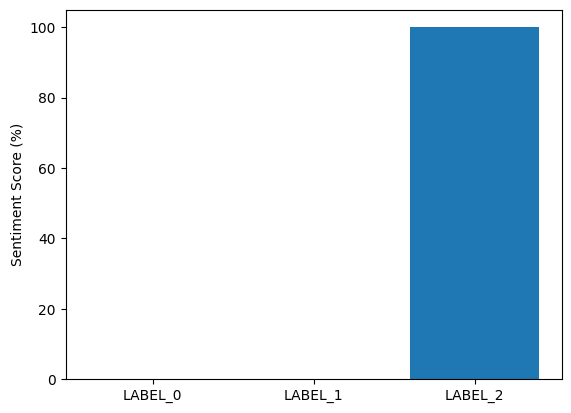

In [70]:
preds_df = pd.DataFrame(results[0])
labels = preds_df['label'].tolist()
plt.bar(labels, 100*preds_df['score'], color='C0')
plt.ylabel('Sentiment Score (%)')
plt.show()